保持原始变量分布形态进行聚类

In [2]:
import os
os.chdir(r'/Users/zhanghui/商业分析工具和应用/Python/Python_book/14Clustor')

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:

profile_telecom = pd.read_csv('profile_telecom.csv')
profile_telecom.head()

,ID,cnt_call,cnt_msg,cnt_wei,cnt_web
0,1964627,46,90,36,31
1,3107769,53,2,0,2
2,3686296,28,24,5,8
3,3961002,9,2,0,4
4,4174839,145,2,0,1


In [5]:
#计算数据的相关性矩阵
profile_telecom.ix[:,1:].corr()

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  
/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


,cnt_call,cnt_msg,cnt_wei,cnt_web
cnt_call,1.000000,0.052096,0.117832,0.114190
cnt_msg,0.052096,1.000000,0.510686,0.739506
cnt_wei,0.117832,0.510686,1.000000,0.950492
cnt_web,0.114190,0.739506,0.950492,1.000000


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


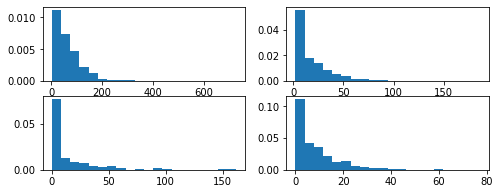

In [8]:
#各个变量的分布情况
plt.figure(figsize = (8,3))
for i in range(4):
    plt.subplot(220+i+1)
    plt.hist(profile_telecom.iloc[:,i+1],bins = 20,normed = True)
    
plt.show()

可以发现每个变量都是偏态分布，因为高消费的客户总是少数，大多数都在中低档

In [10]:
#中心标准化

from sklearn.preprocessing import scale
from sklearn.cluster import KMeans

k =4
tele_scaled = scale(profile_telecom.ix[:,1:])
tele_kmeans = KMeans(n_clusters = k,n_init =15).fit(tele_scaled)
tele_kmeans.cluster_centers_

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  import sys
/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


array([[ 0.04525479,  0.89415401,  0.56707977,  0.73526001],
       [ 0.39035452,  1.71921055,  3.32673647,  3.18414517],
       [-0.2145554 , -0.49172093, -0.46821962, -0.5285122 ],
       [ 4.07714914, -0.2997685 , -0.29238829, -0.31809185]])

In [11]:
#评估模型效果
from sklearn.metrics import silhouette_score
silhouette_score(tele_scaled,tele_kmeans.labels_)

0.4649262558707401

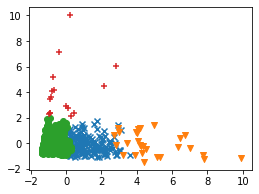

In [18]:
from sklearn.decomposition import PCA

#主成分分析
plt.figure(figsize = [4,3])
tele_pca = PCA(n_components = 2)
tele_pca_score = tele_pca.fit_transform(tele_scaled)
marker = 'xvo+*^dDhs<>'

for cluster,marker in zip(range(k),marker[:k]):
    x_axis = tele_pca_score[:,0][tele_kmeans.labels_ == cluster]
    y_axis = tele_pca_score[:,1][tele_kmeans.labels_ == cluster]
    plt.scatter(x_axis,y_axis,marker = marker)
    
plt.show()

In [19]:
pd.DataFrame(tele_pca_score).groupby(tele_kmeans.labels_).count()

,0,1
0,166,166
1,28,28
2,390,390
3,16,16


对变量进行分布形态转换后聚类

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


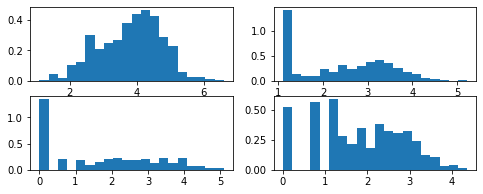

In [24]:
#取对数变换
log_telecom = np.log1p(profile_telecom.iloc[:,1:])
plt.figure(figsize = (8,3))
for i in range(4):
    plt.subplot(220+i+1)
    plt.hist(log_telecom.iloc[:,i], bins = 20, normed = True)
    
plt.show()

In [25]:
#维度分析
log_pca = PCA(n_components = 2, whiten = True)
log_pca_score = log_pca.fit_transform(scale(log_telecom))
print('variance_ratio:',log_pca.explained_variance_ratio_)

variance_ratio: [0.71197124 0.22755356]


从结果来看，前两个主成分能解释94%的数据变异，因此保留两个主成分是合理的

In [30]:
log_pca_kmeans = KMeans(n_clusters = 3, n_init = 15).fit(log_pca_score)
silhouette_score(log_pca_score,log_pca_kmeans.labels_)

0.44549776892026804

In [31]:
co = profile_telecom.iloc[:,1:5].groupby(log_pca_kmeans.labels_).mean()
co

,cnt_call,cnt_msg,cnt_wei,cnt_web
0,69.227941,31.422794,30.772059,16.702206
1,104.732955,5.636364,1.534091,2.261364
2,13.769737,7.342105,1.611842,2.546053


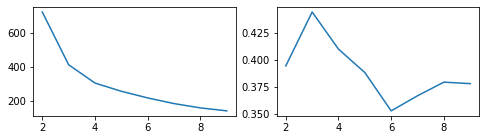

In [32]:
#不同聚类的离差平方和和轮廓系数
plt.figure(figsize = [8,2])
ks = range(2,10)

rssds = [];silhs = []
for k in ks:
    model = KMeans(n_clusters = k, n_init = 15)
    model.fit(log_pca_score)
    rssds.append(model.inertia_)
    silhs.append(silhouette_score(log_pca_score,model.labels_))

plt.subplot(121),plt.plot(ks,rssds)
plt.subplot(122),plt.plot(ks,silhs)
plt.show()

由左图可知，离差平方和从2下降到3最明显，因此分为3类是最优的；
由右图可知，轮廓系数在k=3时最大。